In [21]:
# 把输出图片包装成函数
import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from tqdm import *

rcParams["font.family"] = "SimHei"
np.seterr(divide="ignore", invalid="ignore")


def print_img(img, title):
    if img.ndim == 3:  # cv库的图片是bgr，输出要先转回rgb
        img = img[:, :, ::-1]
    plt.title(title)
    plt.imshow(img, plt.cm.gray)  # rgb会忽略颜色指定
    plt.show()


def read_img(path):
    img = plt.imread(path)  # plt读图，rgb格式，可读中文路径，用cv2的可以改系统utf8(beta)编码
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, (480, 270))
    return img

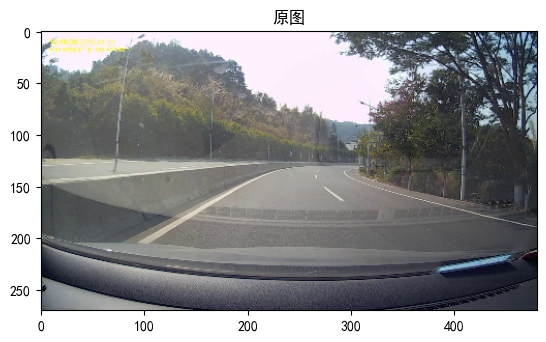

In [22]:
## 1. 先读入读图
img = read_img(r"C:\Code\JupyterLab\lane_detection\video_frame\03500.jpg")

print_img(img, "原图")

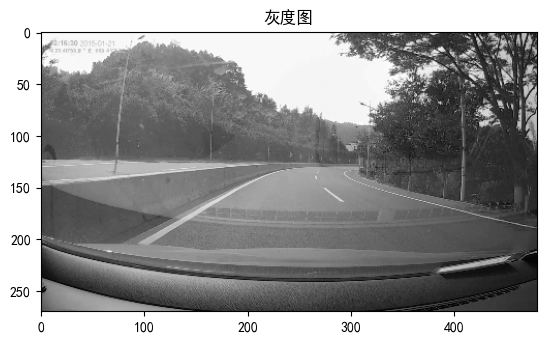

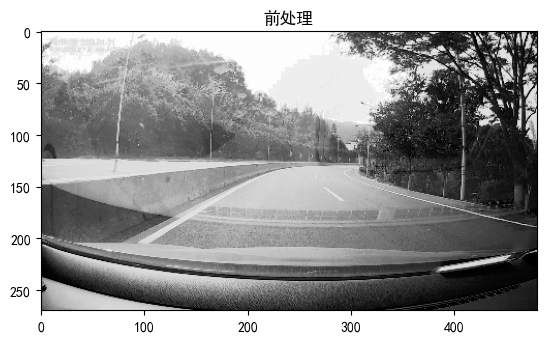

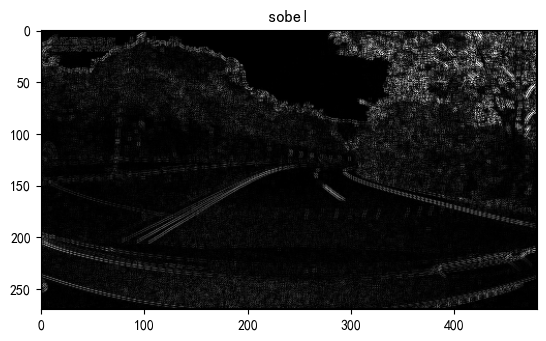

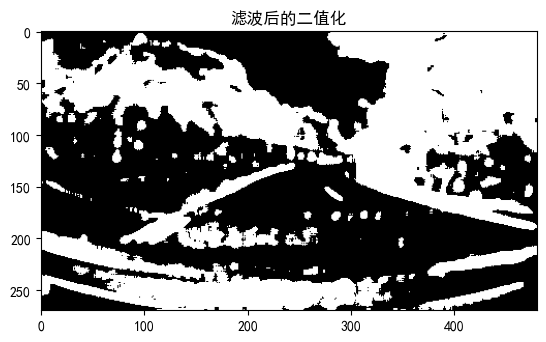

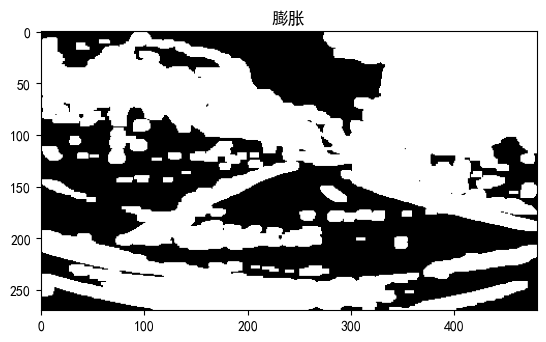

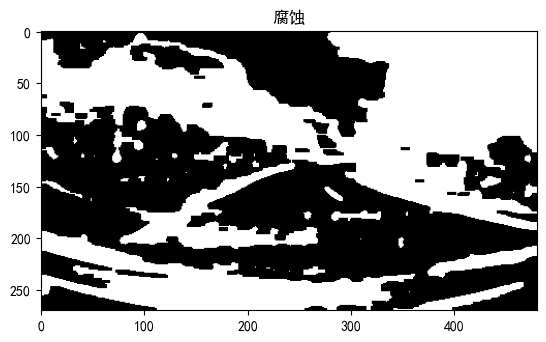

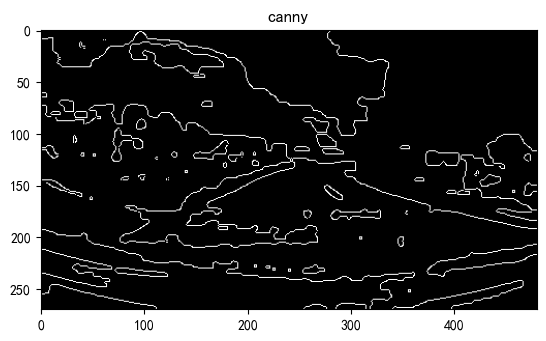

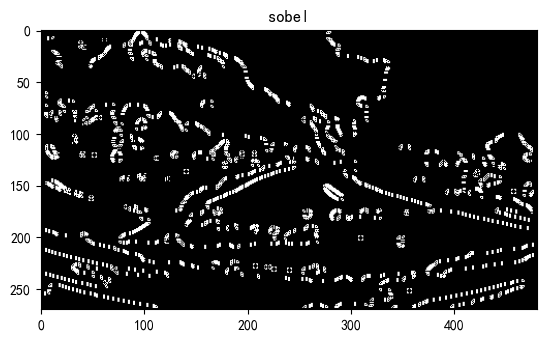

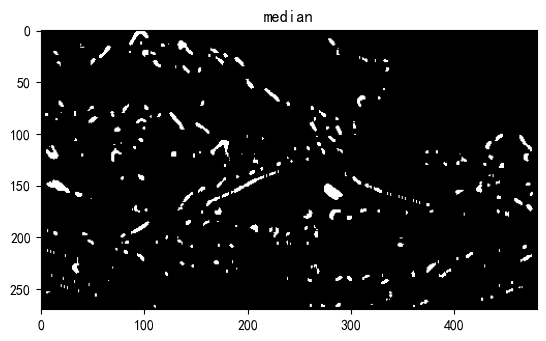

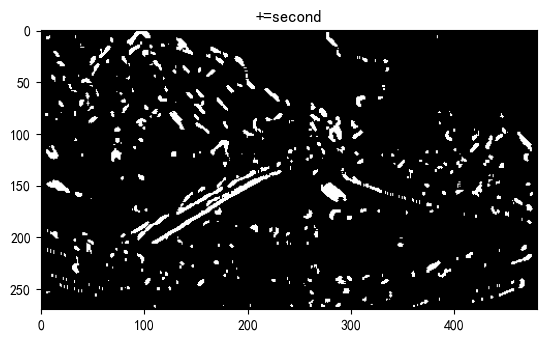

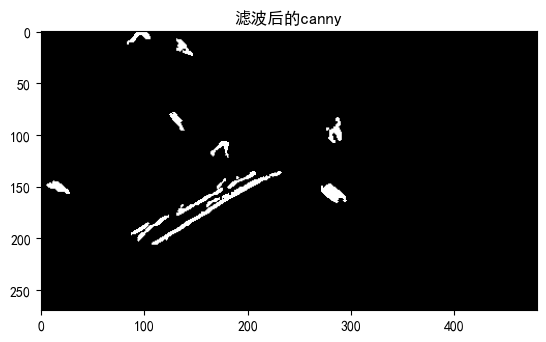

In [23]:
# 3.1 利用canny算子把图片中的边缘提取出来


low_threshold = 200
high_threshold = 250
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
print_img(gray, "灰度图")

canny_image = gray.copy()
second_cannel = gray.copy()
if np.mean(canny_image) < 50:
    th, canny_image = cv2.threshold(canny_image, 70, 255, cv2.THRESH_BINARY)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        canny_image, connectivity=8, ltype=None
    )
    for area in range(1, len(stats)):
        if stats[area][4] > 3000:
            print(stats[area][1], stats[area][1] + stats[area][3])
            print(stats[area][0], stats[area][0] + stats[area][2])
            for i in range(stats[area][1], stats[area][1] + stats[area][3]):
                for j in range(stats[area][0], stats[area][0] + stats[area][2]):
                    canny_image[i, j] = 0
else:
    canny_image = cv2.equalizeHist(canny_image)
print_img(canny_image, "前处理")


second_cannel = cv2.Sobel(second_cannel, cv2.CV_16S, 1, 1)
second_cannel = cv2.convertScaleAbs(second_cannel)
canny_image = cv2.Sobel(canny_image, cv2.CV_16S, 1, 1)
canny_image = cv2.convertScaleAbs(canny_image)
print_img(second_cannel, "sobel")

second_cannel = cv2.blur(second_cannel, (7, 7))
canny_image = cv2.blur(canny_image, (7, 7))

th, second_cannel = cv2.threshold(second_cannel, 15, 255, cv2.THRESH_BINARY)
th, canny_image = cv2.threshold(canny_image, 15, 255, cv2.THRESH_BINARY)
print_img(canny_image, "滤波后的二值化")

second_cannel = cv2.dilate(second_cannel, cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3)))
canny_image = cv2.dilate(canny_image, cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3)))
print_img(canny_image, "膨胀")

second_cannel = cv2.erode(second_cannel, cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3)))
canny_image = cv2.erode(canny_image, cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3)))
print_img(canny_image, "腐蚀")

second_cannel = cv2.Canny(second_cannel, low_threshold, high_threshold)
second_cannel = cv2.Sobel(second_cannel, cv2.CV_16S, 1, 1)
second_cannel = cv2.convertScaleAbs(second_cannel)
second_cannel = cv2.medianBlur(second_cannel, 5)

canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)
print_img(canny_image, "canny")
canny_image = cv2.Sobel(canny_image, cv2.CV_16S, 1, 1)
canny_image = cv2.convertScaleAbs(canny_image)
print_img(canny_image, "sobel")

canny_image = cv2.medianBlur(canny_image, 5)
print_img(canny_image, "median")

canny_image += second_cannel
print_img(canny_image, "+=second")

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
    canny_image, connectivity=8, ltype=None
)
for area in range(1, len(stats)):
    if stats[area][4] < 100:
        for i in range(stats[area][1], stats[area][1] + stats[area][3]):
            for j in range(stats[area][0], stats[area][0] + stats[area][2]):
                canny_image[i, j] = 0

print_img(canny_image, "滤波后的canny")


# 可见画面依旧不是特别干净,还是有零碎的小点

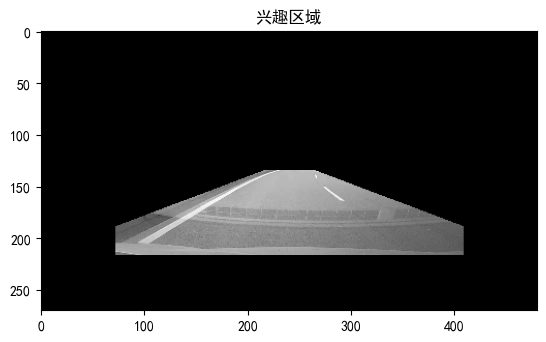

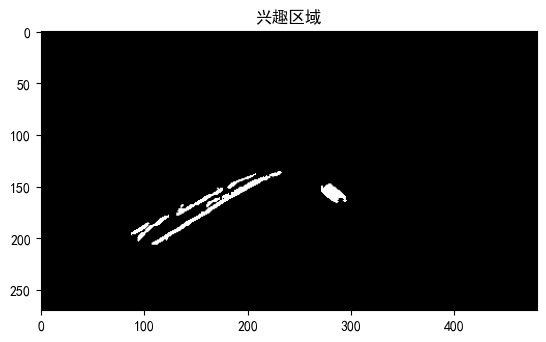

In [24]:
# 提取兴趣区域，因为车道线只会在下三角区域（以下设置为梯形区域，一并去除视频视角下的车前盖）
def region_of_interest(img):
    # 定义一个和输入图像同样大小的全黑图像掩膜
    mask = np.zeros_like(img)
    ignore_mask_color = 255

    left_bottom = [img.shape[1] * 0.15, img.shape[0] * 0.8]
    left_low = [img.shape[1] * 0.15, img.shape[0] * 0.70]
    apex_1 = [img.shape[1] * 0.45, img.shape[0] * 0.50]
    apex_2 = [img.shape[1] * 0.55, img.shape[0] * 0.50]
    right_low = [img.shape[1] * 0.85, img.shape[0] * 0.70]
    right_bottom = [img.shape[1] * 0.85, img.shape[0] * 0.8]
    vertices = np.array([left_bottom, left_low, apex_1, apex_2, right_low, right_bottom], np.int32)

    # [vertices]中的点组成了多边形，将在多边形内的掩膜像素点保留，
    cv2.fillPoly(mask, [vertices], ignore_mask_color)

    # 和掩膜做"与"操作，即仅留下多边形部分的图像
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image


roi_image = region_of_interest(canny_image)
a = region_of_interest(gray)
print_img(a, "兴趣区域")
print_img(roi_image, "兴趣区域")

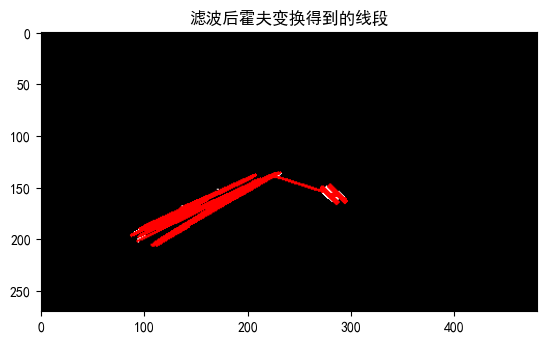

In [25]:
# 霍夫变换
import copy

rho = 1  # 像素精度，一般设置为1
theta = np.pi / 180  # 角度精度，一般设置为PI/180
threshold = 20  # 表示累计的像素达到多少才能形成直线
min_line_length = 15  # 最小的线段长度
max_line_gap = 80  # 两条线的间隔如果小于这个值为一条线

# 霍夫变换函数
hough_lines = cv2.HoughLinesP(
    roi_image, rho, theta, threshold, np.array([]), min_line_length, max_line_gap
)


# 划线函数
def draw_lines(img, lines, color=[0, 0, 255], thickness=2):
    img = copy.deepcopy(img)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    if lines is None:
        return img
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)  # 将线段绘制在img上
    return img


lines_image = draw_lines(roi_image, hough_lines)
print_img(lines_image, "滤波后霍夫变换得到的线段")

In [26]:
import math


def adjust_intersecting_lines(x1, y1, x2, y2, x3, y3, x4, y4):
    # 判断线段是否相交
    def lines_intersect(x1, y1, x2, y2, x3, y3, x4, y4):
        def ccw(x1, y1, x2, y2, x3, y3):
            return (y3 - y1) * (x2 - x1) < (y2 - y1) * (x3 - x1)

        return ccw(x1, y1, x3, y3, x4, y4) != ccw(x2, y2, x3, y3, x4, y4) and ccw(
            x1, y1, x2, y2, x3, y3
        ) != ccw(x1, y1, x2, y2, x4, y4)

    # 计算斜率
    def calculate_slope(x1, y1, x2, y2):
        if x1 != x2:
            return (y2 - y1) / (x2 - x1)
        else:
            return float("inf")

    # 计算线段长度
    def calculate_distance(x1, y1, x2, y2):
        return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    # 获取线段的交点
    def get_intersection_point(x1, y1, x2, y2, x3, y3, x4, y4):
        slope1 = calculate_slope(x1, y1, x2, y2)
        slope2 = calculate_slope(x3, y3, x4, y4)

        if slope1 == slope2:
            return None  # 平行线段没有交点

        if slope1 == float("inf"):
            x = x1
            y = slope2 * (x - x3) + y3
        elif slope2 == float("inf"):
            x = x3
            y = slope1 * (x - x1) + y1
        else:
            x = (y3 - y1 + slope1 * x1 - slope2 * x3) / (slope1 - slope2)
            y = slope1 * (x - x1) + y1

        return int(x), int(y)

    # 缩短线段长度
    def shorten_line(x1, y1, x2, y2, ratio):
        distance = calculate_distance(x1, y1, x2, y2)
        new_distance = distance * ratio
        dx = (x2 - x1) / distance
        dy = (y2 - y1) / distance
        new_x2 = x1 + dx * new_distance
        new_y2 = y1 + dy * new_distance
        return int(new_x2), int(new_y2)

    # 判断线段是否相交
    if lines_intersect(x1, y1, x2, y2, x3, y3, x4, y4):
        intersection_point = get_intersection_point(x1, y1, x2, y2, x3, y3, x4, y4)
        if intersection_point:
            ratio = 0.9
            x2, y2 = shorten_line(x1, y1, intersection_point[0], intersection_point[1], ratio)
            x4, y4 = shorten_line(x3, y3, intersection_point[0], intersection_point[1], ratio)

    return x1, y1, x2, y2, x3, y3, x4, y4

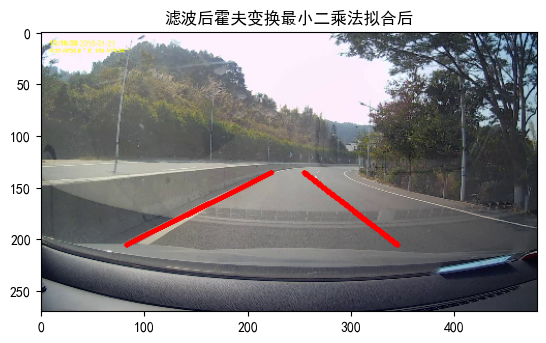

In [28]:
# 用最小二乘法拟合车道线
def draw_lines_2(img, lines, color=[255, 0, 0], thickness=4):
    img = copy.deepcopy(img)
    left_lines_x = []
    left_lines_y = []
    right_lines_x = []
    right_lines_y = []
    line_y_max = 0
    line_y_min = 999
    # 所有线段用斜率确定左右
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                if y1 > line_y_max:
                    line_y_max = y1
                if y2 > line_y_max:
                    line_y_max = y2
                if y1 < line_y_min:
                    line_y_min = y1
                if y2 < line_y_min:
                    line_y_min = y2
                k = (y2 - y1) / (x2 - x1)
                # print(k)
                # print(x1, y1, x2, y2)
                if k <= -0.4 and x1 < img.shape[1] * 0.3:
                    left_lines_x.append(x1)
                    left_lines_y.append(y1)
                    left_lines_x.append(x2)
                    left_lines_y.append(y2)
                elif k >= 0.4 and x2 > img.shape[1] * 0.5:
                    right_lines_x.append(x1)
                    right_lines_y.append(y1)
                    right_lines_x.append(x2)
                    right_lines_y.append(y2)
                    # print(k)
    # 最小二乘直线拟合
    left_exists = False
    right_exists = False
    left_x1, left_y1, left_x2, left_y2 = -1, -1, -1, -1
    right_x1, right_y1, right_x2, right_y2 = -1, -1, -1, -1

    if left_lines_x != [] and left_lines_y != []:
        left_exists = True
        left_line_k, left_line_b = np.polyfit(left_lines_x, left_lines_y, 1)
        left_x1 = int((line_y_max - left_line_b) / left_line_k)
        left_y1 = line_y_max
        left_x2 = int((line_y_min - left_line_b) / left_line_k)
        left_y2 = int(line_y_min)

    if right_lines_x != [] and right_lines_y != []:
        right_exists = True
        right_line_k, right_line_b = np.polyfit(right_lines_x, right_lines_y, 1)
        right_x1 = int((line_y_max - right_line_b) / right_line_k)
        right_y1 = line_y_max
        right_x2 = int((line_y_min - right_line_b) / right_line_k)
        right_y2 = int(line_y_min)

    if left_exists is True and right_exists is True:
        (
            left_x1,
            left_y1,
            left_x2,
            left_y2,
            right_x1,
            right_y1,
            right_x2,
            right_y2,
        ) = adjust_intersecting_lines(
            left_x1, left_y1, left_x2, left_y2, right_x1, right_y1, right_x2, right_y2
        )
        cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)
        cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
    elif left_exists is True:
        cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)
    elif right_exists is True:
        cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
    return img


processed_image = draw_lines_2(img, hough_lines, color=[0, 0, 255], thickness=4)
print_img(processed_image, "滤波后霍夫变换最小二乘法拟合后")

In [29]:
# 3.1 利用canny算子把图片中的边缘提取出来
def get_edge(img):
    low_threshold = 200
    high_threshold = 250

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    canny_image = gray.copy()
    second_cannel = gray.copy()
    night_flag = False
    if np.mean(canny_image) < 50:
        night_flag = True
        th, canny_image = cv2.threshold(canny_image, 70, 255, cv2.THRESH_BINARY)
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
            canny_image, connectivity=8, ltype=None
        )
        for area in range(1, len(stats)):
            if stats[area][4] > 3000:
                for i in range(stats[area][1], stats[area][1] + stats[area][3]):
                    for j in range(stats[area][0], stats[area][0] + stats[area][2]):
                        canny_image[i, j] = 0
    else:
        canny_image = cv2.equalizeHist(canny_image)

    canny_image = cv2.Sobel(canny_image, cv2.CV_16S, 1, 1)
    canny_image = cv2.convertScaleAbs(canny_image)

    canny_image = cv2.blur(canny_image, (7, 7))

    th, canny_image = cv2.threshold(canny_image, 15, 255, cv2.THRESH_BINARY)

    canny_image = cv2.dilate(canny_image, cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3)))

    canny_image = cv2.erode(canny_image, cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3)))

    canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)

    canny_image = cv2.Sobel(canny_image, cv2.CV_16S, 1, 1)
    canny_image = cv2.convertScaleAbs(canny_image)

    canny_image = cv2.medianBlur(canny_image, 5)

    second_cannel = cv2.Sobel(second_cannel, cv2.CV_16S, 1, 1)
    second_cannel = cv2.convertScaleAbs(second_cannel)
    second_cannel = cv2.blur(second_cannel, (7, 7))
    th, second_cannel = cv2.threshold(second_cannel, 15, 255, cv2.THRESH_BINARY)
    second_cannel = cv2.dilate(second_cannel, cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3)))
    second_cannel = cv2.erode(second_cannel, cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3)))
    second_cannel = cv2.Canny(second_cannel, low_threshold, high_threshold)
    second_cannel = cv2.Sobel(second_cannel, cv2.CV_16S, 1, 1)
    second_cannel = cv2.convertScaleAbs(second_cannel)
    second_cannel = cv2.medianBlur(second_cannel, 5)
    canny_image += second_cannel

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        canny_image, connectivity=8, ltype=None
    )
    for area in range(1, len(stats)):
        if stats[area][4] < 80:
            for i in range(stats[area][1], stats[area][1] + stats[area][3]):
                for j in range(stats[area][0], stats[area][0] + stats[area][2]):
                    canny_image[i, j] = 0

    return canny_image


# 可见画面依旧不是特别干净,还是有零碎的小点

In [30]:
def hough(roi_image):
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 20  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 15  # minimum number of pixels making up a line
    max_line_gap = 80  # maximum gap in pixels between connectable line segments

    hough_lines = cv2.HoughLinesP(
        roi_image, rho, theta, threshold, np.array([]), min_line_length, max_line_gap
    )
    return hough_lines

In [31]:
def lane_detect(source_type, source_path, save_path="./results/", file_name="result_video.mp4"):
    if source_type == "img":
        image = read_img(source_path)
        canny_image = get_edge(image)
        roi_image = region_of_interest(canny_image)
        hough_lines = hough(roi_image)
        processed_image = draw_lines_2(image, hough_lines, color=[0, 0, 255], thickness=4)
        print_img(processed_image, "处理结果")
    elif source_type == "video":
        video_reader = cv2.VideoCapture(source_path)
        total_frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_count = 0
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        video_writer = cv2.VideoWriter(save_path + file_name, fourcc, 30, (480, 270))
        if video_reader.isOpened():
            print("开始处理视频...")
        else:
            print("打开视频失败！")
            return
        with tqdm(total=total_frame_count) as pbar:
            while video_reader.isOpened():
                ret, frame = video_reader.read()
                if ret:
                    frame = cv2.resize(frame, (480, 270))
                    canny_image = get_edge(frame)
                    roi_image = region_of_interest(canny_image)
                    hough_lines = hough(roi_image)
                    processed_image = draw_lines_2(
                        frame, hough_lines, color=[0, 0, 255], thickness=4
                    )
                    video_writer.write(processed_image)
                    frame_count += 1
                else:
                    pbar.update(total_frame_count - frame_count)
                    pbar.close()
                    print("处理完毕!")
                    print("结果保存至%s%s" % (save_path, "video_result.mp4"))
                    break
                pbar.update(1)
        video_reader.release()
        video_writer.release()
    else:
        print("source_type 错误！")

In [32]:
source_type = "video"
source_path = r"C:\Code\Dataset\car_net_hw\2-中山大学-张荣辉-车道线检测素材-20230505.AVI"
save_path = "./results/"
file_name = "result_video.mp4"
lane_detect("video", r"C:\Code\Dataset\car_net_hw\2-中山大学-张荣辉-车道线检测素材-20230505.AVI")

开始处理视频...


100%|███████████████████████████████████████████████████████████████████████████| 17962/17962 [02:56<00:00, 101.63it/s]

处理完毕!
结果保存至./results/video_result.mp4


In [5]:
# 图片转视频
import cv2
from tqdm import *

source_path = r"C:\Code\clrnet result\result_310"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = cv2.VideoWriter("video_result_llamas_310.mp4", fourcc, 30, (1276, 717))
count = 0
print("开始转换...")
with tqdm(total=17704) as pbar:
    while count < 17704:
        count_str = "%05d" % count
        count += 1
        file_name = source_path + "\\" + count_str + ".jpg"
        frame = cv2.imread(file_name)
        video_writer.write(frame)
        pbar.update(1)
pbar.close()
video_writer.release()
print("转换完毕！")

开始转换...


100%|████████████████████████████████████████████████████████████████████████████| 17704/17704 [03:42<00:00, 79.74it/s]

转换完毕！


In [1]:
# 视频缩放至culane数据集大小
import cv2

video_reader = cv2.VideoCapture(r"C:\Code\Dataset\car_net_hw\2-中山大学-张荣辉-车道线检测素材-20230505.AVI")
count = 0
while video_reader.isOpened():
    ret, frame = video_reader.read()
    if ret:
        count_str = "%05d" % count
        count += 1
        file_name = "./video_1640_590/" + count_str + ".jpg"
        print(file_name)
        frame = cv2.resize(frame, (1640, 590))
        cv2.imwrite(file_name, frame)
    else:
        video_reader.release()
video_reader.release()

./video_1640_590/00000.jpg
./video_1640_590/00001.jpg
./video_1640_590/00002.jpg
./video_1640_590/00003.jpg
./video_1640_590/00004.jpg
./video_1640_590/00005.jpg
./video_1640_590/00006.jpg
./video_1640_590/00007.jpg
./video_1640_590/00008.jpg
./video_1640_590/00009.jpg
./video_1640_590/00010.jpg
./video_1640_590/00011.jpg
./video_1640_590/00012.jpg
./video_1640_590/00013.jpg
./video_1640_590/00014.jpg
./video_1640_590/00015.jpg
./video_1640_590/00016.jpg
./video_1640_590/00017.jpg
./video_1640_590/00018.jpg
./video_1640_590/00019.jpg
./video_1640_590/00020.jpg
./video_1640_590/00021.jpg
./video_1640_590/00022.jpg
./video_1640_590/00023.jpg
./video_1640_590/00024.jpg
./video_1640_590/00025.jpg
./video_1640_590/00026.jpg
./video_1640_590/00027.jpg
./video_1640_590/00028.jpg
./video_1640_590/00029.jpg
./video_1640_590/00030.jpg
./video_1640_590/00031.jpg
./video_1640_590/00032.jpg
./video_1640_590/00033.jpg
./video_1640_590/00034.jpg
./video_1640_590/00035.jpg
./video_1640_590/00036.jpg
.

In [2]:
# 视频缩放至llamas数据集大小
import cv2

video_reader = cv2.VideoCapture(r"C:\Code\Dataset\car_net_hw\2-中山大学-张荣辉-车道线检测素材-20230505.AVI")
count = 0
while video_reader.isOpened():
    ret, frame = video_reader.read()
    if ret:
        count_str = "%05d" % count
        count += 1
        file_name = "./video_1276_717/" + count_str + ".jpg"
        print(file_name)
        frame = cv2.resize(frame, (1276, 717))
        cv2.imwrite(file_name, frame)
    else:
        video_reader.release()
video_reader.release()

./video_1276_717/00000.jpg
./video_1276_717/00001.jpg
./video_1276_717/00002.jpg
./video_1276_717/00003.jpg
./video_1276_717/00004.jpg
./video_1276_717/00005.jpg
./video_1276_717/00006.jpg
./video_1276_717/00007.jpg
./video_1276_717/00008.jpg
./video_1276_717/00009.jpg
./video_1276_717/00010.jpg
./video_1276_717/00011.jpg
./video_1276_717/00012.jpg
./video_1276_717/00013.jpg
./video_1276_717/00014.jpg
./video_1276_717/00015.jpg
./video_1276_717/00016.jpg
./video_1276_717/00017.jpg
./video_1276_717/00018.jpg
./video_1276_717/00019.jpg
./video_1276_717/00020.jpg
./video_1276_717/00021.jpg
./video_1276_717/00022.jpg
./video_1276_717/00023.jpg
./video_1276_717/00024.jpg
./video_1276_717/00025.jpg
./video_1276_717/00026.jpg
./video_1276_717/00027.jpg
./video_1276_717/00028.jpg
./video_1276_717/00029.jpg
./video_1276_717/00030.jpg
./video_1276_717/00031.jpg
./video_1276_717/00032.jpg
./video_1276_717/00033.jpg
./video_1276_717/00034.jpg
./video_1276_717/00035.jpg
./video_1276_717/00036.jpg
.